In [1]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.Size([1, 3, 256, 256])


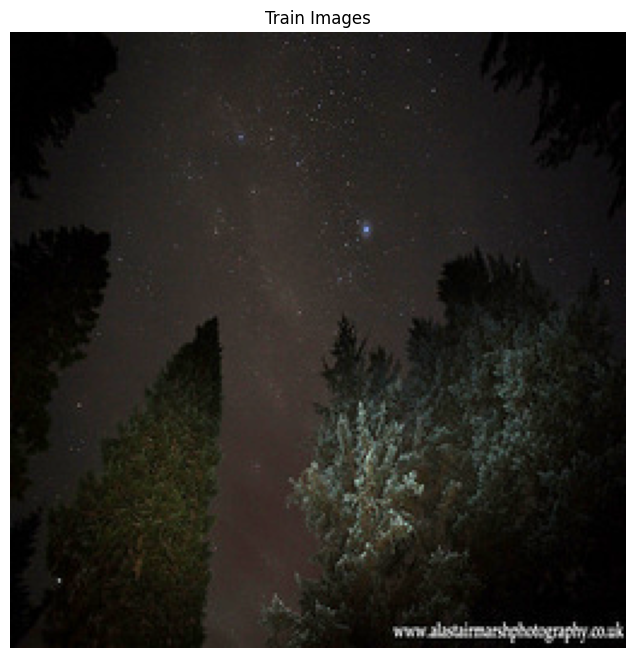

In [3]:
batch_size = 1
workers = 2
image_size = (256, 256)

dataroot = '../data/processed/content_train/'

dataset_content_train = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1)),
        ],
    ),
)

dataloader_content_train = torch.utils.data.DataLoader(
    dataset_content_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

real_batch = next(iter(dataloader_content_train))
print(real_batch[0].shape)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Train Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(), (1, 2, 0)))

torch.Size([1, 3, 256, 256])


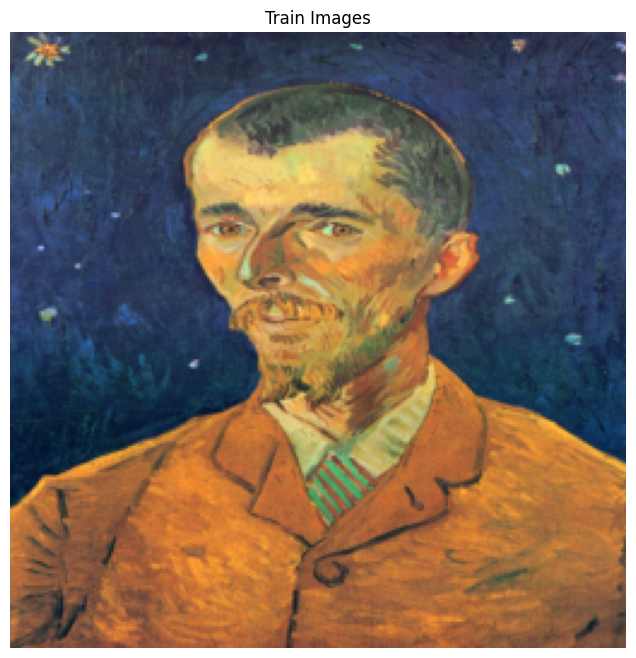

In [4]:
dataroot = '../data/processed/paintings_train/'

dataset_paintings_train = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1)),
        ],
    ),
)

dataloader_paintings_train = torch.utils.data.DataLoader(
    dataset_paintings_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

real_batch = next(iter(dataloader_paintings_train))
print(real_batch[0].shape)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Train Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(), (1, 2, 0)))

torch.Size([1, 3, 256, 256])


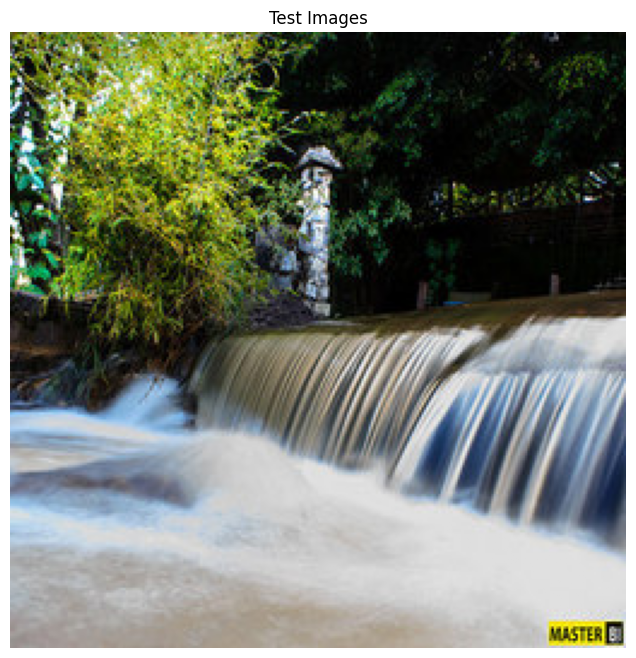

In [5]:
dataroot = '../data/processed/content_test/'

dataset_content_test = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1)),
        ],
    ),
)

dataloader_content_test = torch.utils.data.DataLoader(
    dataset_content_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

real_batch = next(iter(dataloader_content_test))
print(real_batch[0].shape)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Test Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(), (1, 2, 0)))

torch.Size([1, 3, 256, 256])


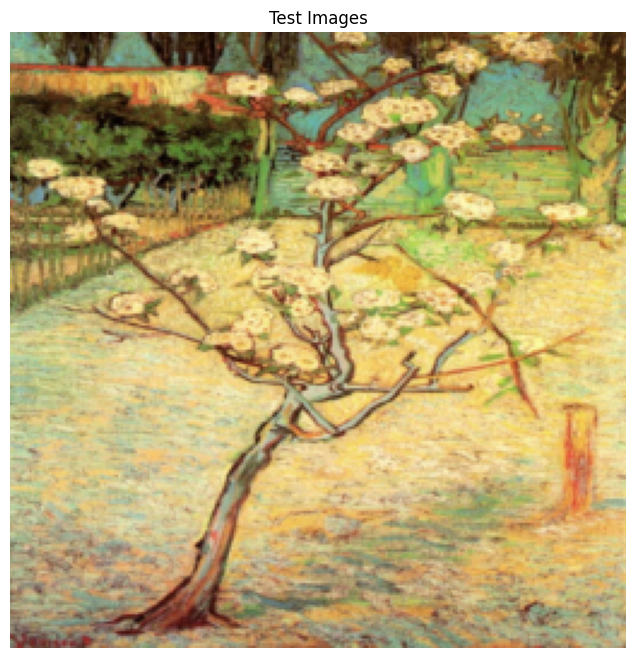

In [6]:
dataroot = '../data/processed/paintings_test/'

dataset_paintings_test = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1)),
        ],
    ),
)

dataloader_paintings_test = torch.utils.data.DataLoader(
    dataset_paintings_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

real_batch = next(iter(dataloader_paintings_test))
print(real_batch[0].shape)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Test Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [7]:
def plot_images_test(dataset_content_test, dataloader_paintings_test):
    batch_a_test = next(iter(dataset_content_test))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test).cpu().detach()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(
        vutils.make_grid((real_a_test[:4] + 1) / 2, padding=2,
                         normalize=True).cpu(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Real content')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(
        vutils.make_grid((fake_b_test[:4] + 1) / 2, padding=2,
                         normalize=True).cpu(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Fake paintings')
    plt.show()

    batch_b_test = next(iter(dataloader_paintings_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test).cpu().detach()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(
        vutils.make_grid((real_b_test[:4] + 1) / 2, padding=2,
                         normalize=True).cpu(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Real paintings')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(
        vutils.make_grid((fake_a_test[:4] + 1) / 2, padding=2,
                         normalize=True).cpu(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Fake content')
    plt.show()

In [8]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):
    torch.save(G_A2B, name + '_G_A2B.pt')
    torch.save(G_B2A, name + '_G_B2A.pt')
    torch.save(D_A, name + '_D_A.pt')
    torch.save(D_B, name + '_D_B.pt')


def load_models(name):
    G_A2B = torch.load(name + '_G_A2B.pt')
    G_B2A = torch.load(name + '_G_B2A.pt')
    D_A = torch.load(name + '_D_A.pt')
    D_B = torch.load(name + '_D_B.pt')
    return G_A2B, G_B2A, D_A, D_B

In [9]:
norm_layer = nn.InstanceNorm2d


class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f),
                                  nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)

    def forward(self, x):
        return F.relu(self.norm(self.conv(x) + x))


class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(3, f, 7, 1, 0), norm_layer(f), nn.ReLU(True),
                  nn.Conv2d(f, 2 * f, 3, 2, 1), norm_layer(2 * f),
                  nn.ReLU(True),
                  nn.Conv2d(2 * f, 4 * f, 3, 2, 1), norm_layer(4 * f),
                  nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4 * f))
        layers.extend([
            nn.ConvTranspose2d(4 * f, 4 * 2 * f, 3, 1, 1), nn.PixelShuffle(2),
            norm_layer(2 * f), nn.ReLU(True),
            nn.ConvTranspose2d(2 * f, 4 * f, 3, 1, 1), nn.PixelShuffle(2),
            norm_layer(f), nn.ReLU(True),
            nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
            nn.Tanh()])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

In [10]:
nc = 3
ndf = 64


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1),
            nn.InstanceNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf * 8, 1, 4, 1, 1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)

In [11]:
def LSGAN_D(real, fake):
    return (torch.mean((real - 1) ** 2) + torch.mean(fake ** 2))


def LSGAN_G(fake):
    return torch.mean((fake - 1) ** 2)

In [12]:
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_Im = torch.nn.L1Loss() 

lr = 0.0002

beta1 = 0.5

In [13]:
def training(G_A2B, G_B2A, D_A, D_B, num_epochs, name, bs=batch_size, old=True):
    # Training Loop

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_A_losses = []
    D_B_losses = []

    iters = 0
    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_A = []
    disc_B = []

    FDL_A2B_t = []
    FDL_B2A_t = []
    CL_A_t = []
    CL_B_t = []
    ID_B2A_t = []
    ID_A2B_t = []
    disc_A_t = []
    disc_B_t = []

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):

        # For each batch in the dataloader
        for i, (data_content, data_paintings) in enumerate(
                zip(dataloader_content_train, dataloader_paintings_train), 0):

            # Set model input
            a_real = data_content[0].to(device)
            b_real = data_paintings[0].to(device)

            tensor_ones = torch.ones([a_real.shape[0], 1, 14, 14]).cuda()
            tensor_zeros = torch.zeros([a_real.shape[0], 1, 14, 14]).cuda()

            # Genrated images
            b_fake = G_A2B(a_real)
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)

            # Discriminator A
            optimizer_D_A.zero_grad()
            if ((iters > 0 or epoch > 0) and old and iters % 3 == 0):
                rand_int = random.randint(bs, old_a_fake.shape[0] - 1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[
                                                       rand_int - bs:rand_int].detach()))
                D_A_losses.append(Disc_loss_A.item())

            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                D_A_losses.append(Disc_loss_A.item())

            Disc_loss_A.backward()
            optimizer_D_A.step()

            # Discriminator B

            optimizer_D_B.zero_grad()
            if ((iters > 0 or epoch > 0) and old and iters % 3 == 0):
                rand_int = random.randint(bs, old_b_fake.shape[0] - 1)
                Disc_loss_B = LSGAN_D(D_B(b_real), D_B(old_b_fake[
                                                       rand_int - bs:rand_int].detach()))
                D_B_losses.append(Disc_loss_B.item())
            else:
                Disc_loss_B = LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                D_B_losses.append(Disc_loss_B.item())

            Disc_loss_B.backward()
            optimizer_D_B.step()

            # Generator

            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()

            # Fool discriminator
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real) * 5
            Cycle_loss_B = criterion_Im(b_rec, b_real) * 5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real) * 10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real) * 10

            # generator losses

            Loss_G = Fool_disc_loss_A2B + Fool_disc_loss_B2A + Cycle_loss_A + Cycle_loss_B + Id_loss_B2A + Id_loss_A2B
            G_losses.append(Loss_G)

            # Backward propagation
            Loss_G.backward()

            # Optimisation step
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()

            FDL_A2B.append(Fool_disc_loss_A2B)
            FDL_B2A.append(Fool_disc_loss_B2A)
            CL_A.append(Cycle_loss_A)
            CL_B.append(Cycle_loss_B)
            ID_B2A.append(Id_loss_B2A)
            ID_A2B.append(Id_loss_A2B)
            disc_A.append(Disc_loss_A)
            disc_B.append(Disc_loss_B)

            if (iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
            elif (old_b_fake.shape[0] == bs * 5 and b_fake.shape[0] == bs):
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int - 5:rand_int] = b_fake.clone()
                old_a_fake[rand_int - 5:rand_int] = a_fake.clone()
            elif (old_b_fake.shape[0] < 25):
                old_b_fake = torch.cat((b_fake.clone(), old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(), old_a_fake))

            iters += 1
            del data_content, data_paintings, a_real, b_real, a_fake, b_fake

        FDL_A2B_t.append(sum(FDL_A2B) / len(FDL_A2B))
        FDL_B2A_t.append(sum(FDL_B2A) / len(FDL_B2A))
        CL_A_t.append(sum(CL_A) / len(CL_A))
        CL_B_t.append(sum(CL_B) / len(CL_B))
        ID_B2A_t.append(sum(ID_B2A) / len(ID_B2A))
        ID_A2B_t.append(sum(ID_A2B) / len(ID_A2B))
        disc_A_t.append(sum(disc_A) / len(disc_A))
        disc_B_t.append(sum(disc_B) / len(disc_B))

        FDL_A2B = []
        FDL_B2A = []
        CL_A = []
        CL_B = []
        ID_B2A = []
        ID_A2B = []
        disc_B = []
        disc_A = []

        iters = 0
        save_models(G_A2B, G_B2A, D_A, D_B, name)
        
        if (epoch % 5 == 0):
            plot_images_test(dataloader_content_test, dataloader_paintings_test)
            
    return FDL_A2B_t, FDL_B2A_t, CL_A_t, CL_B_t, ID_B2A_t, ID_A2B_t, disc_A_t, disc_B_t

Starting Training Loop...


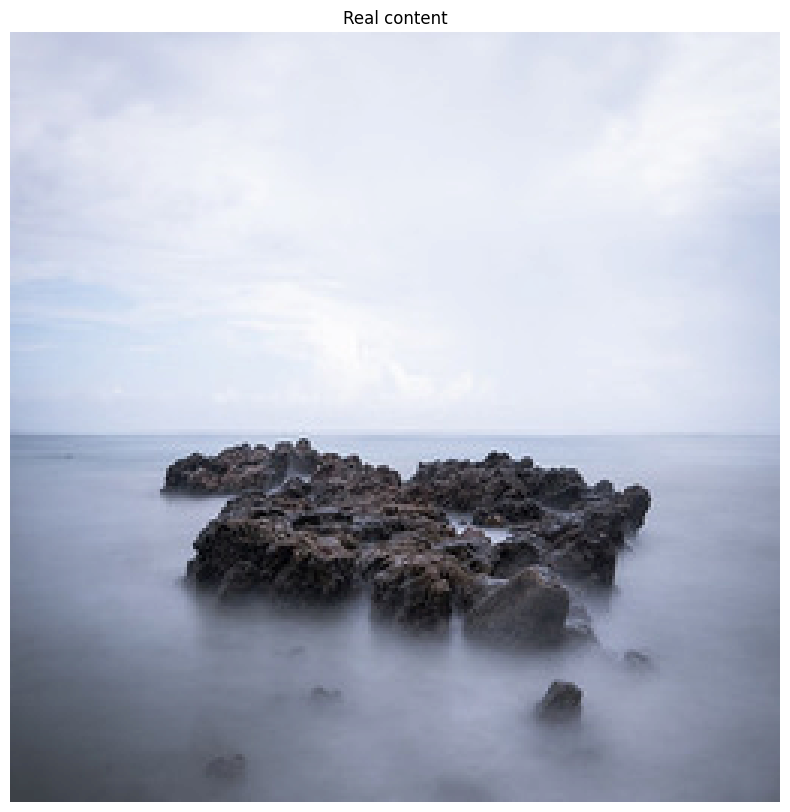

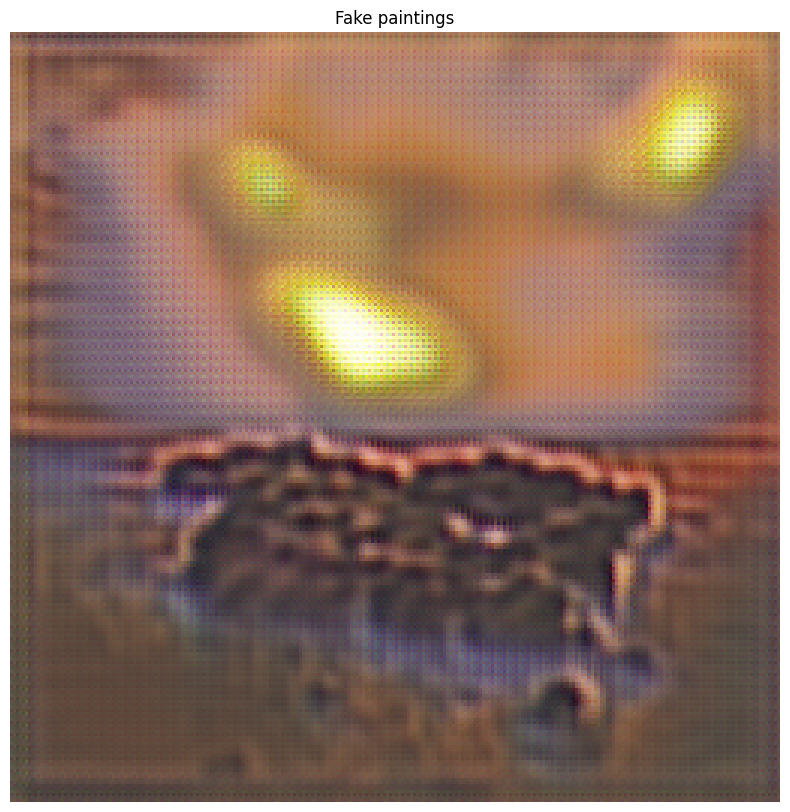

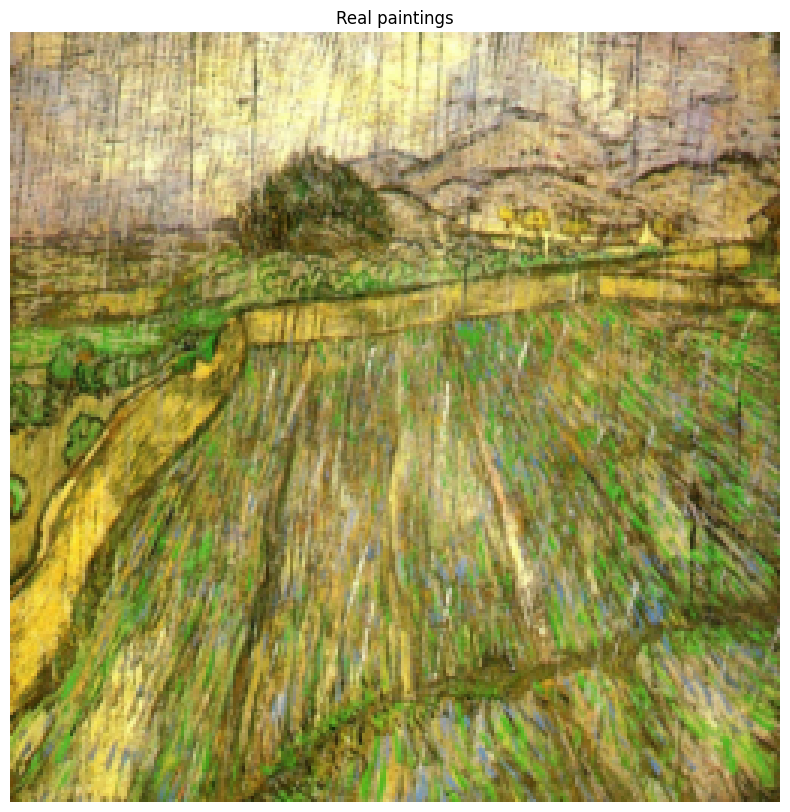

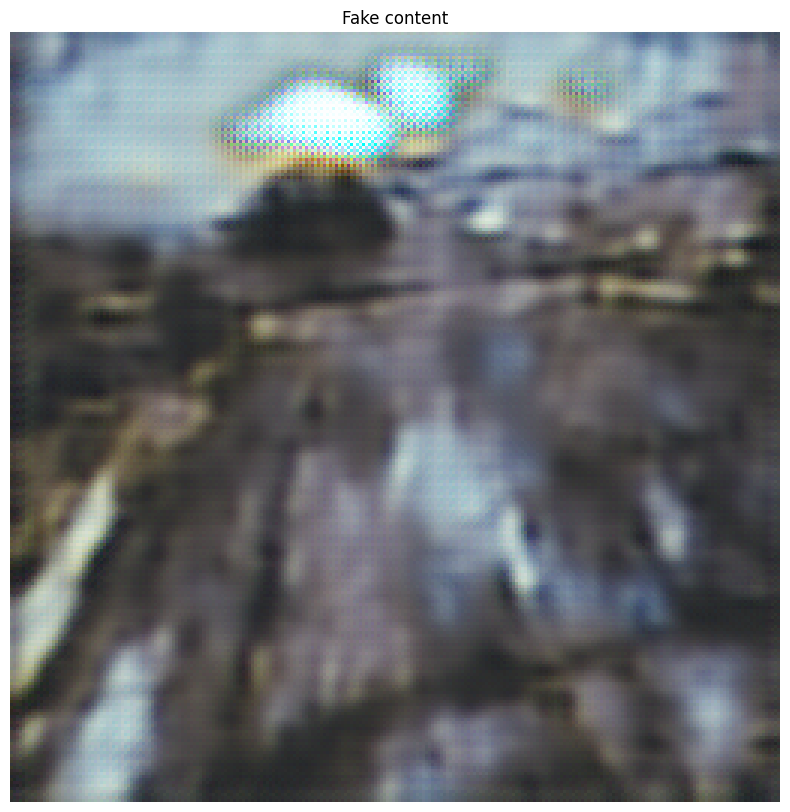

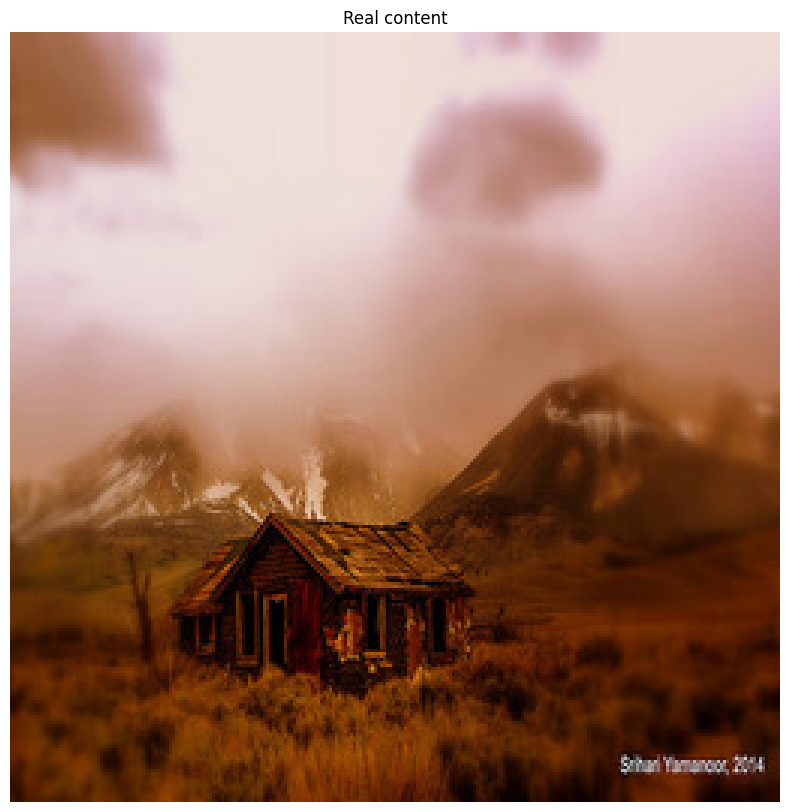

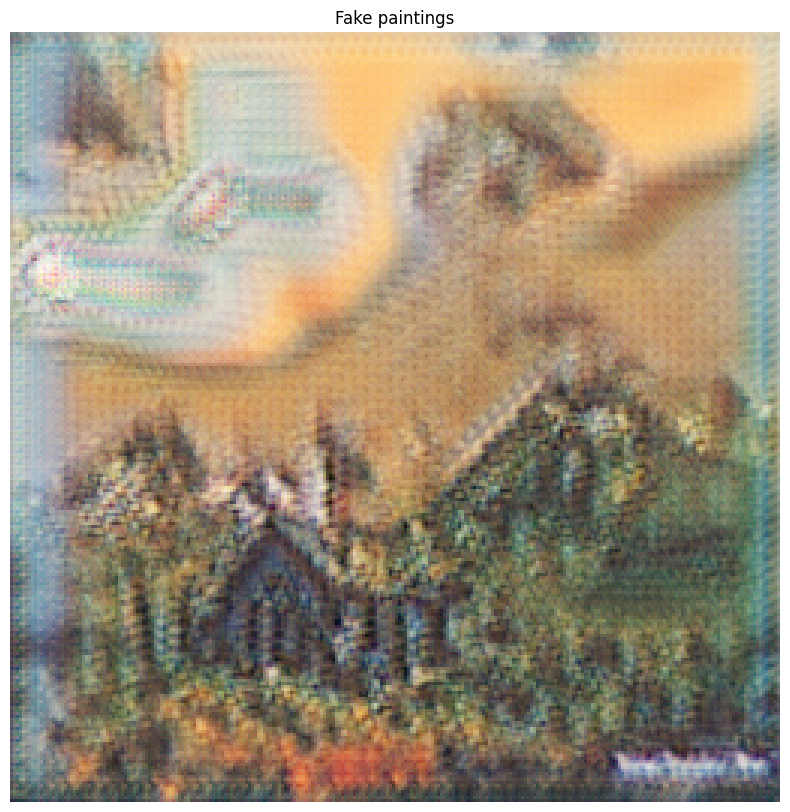

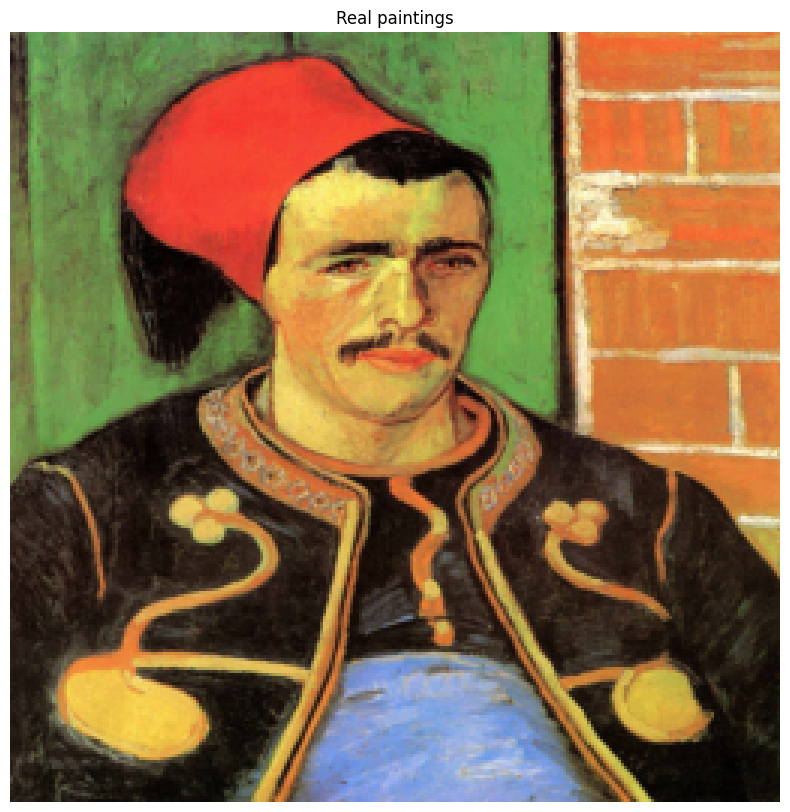

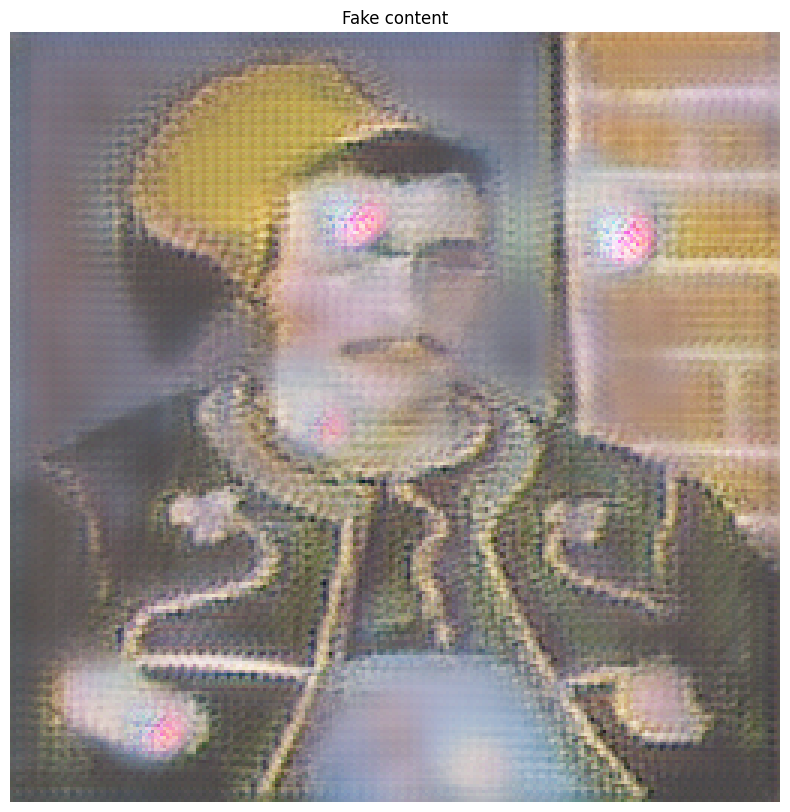

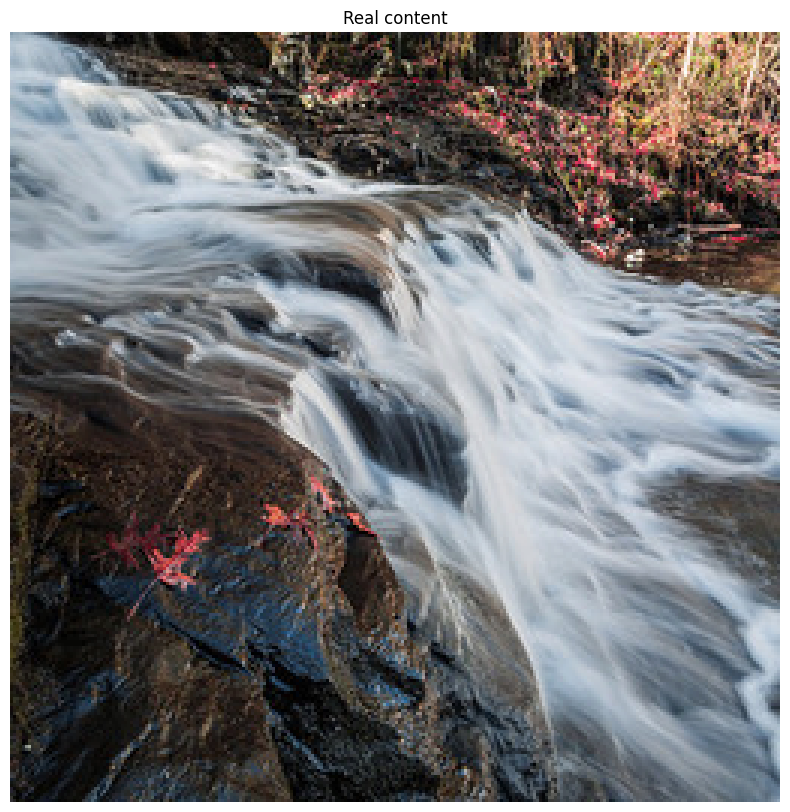

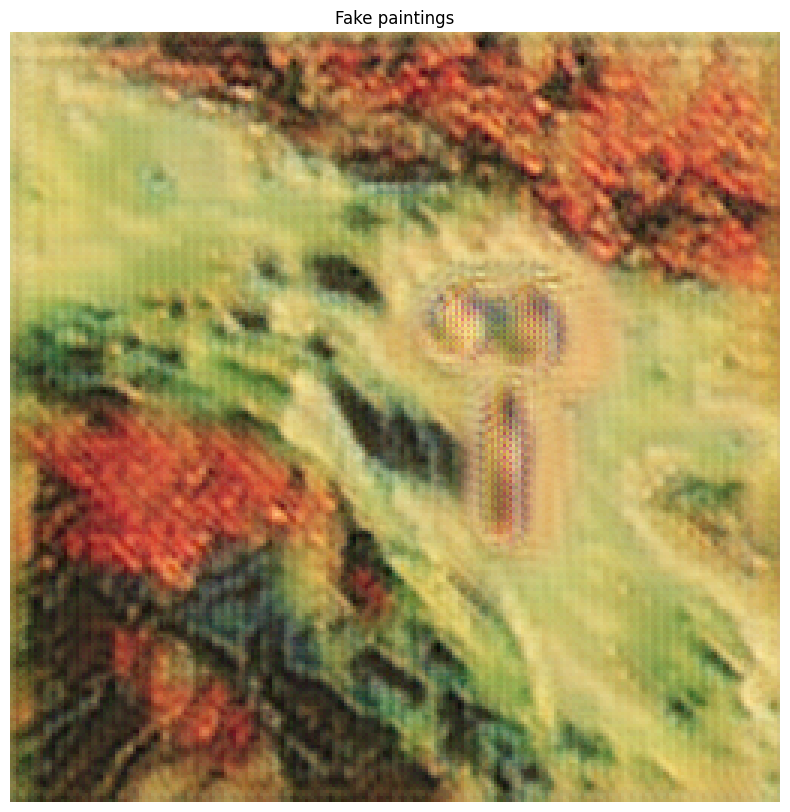

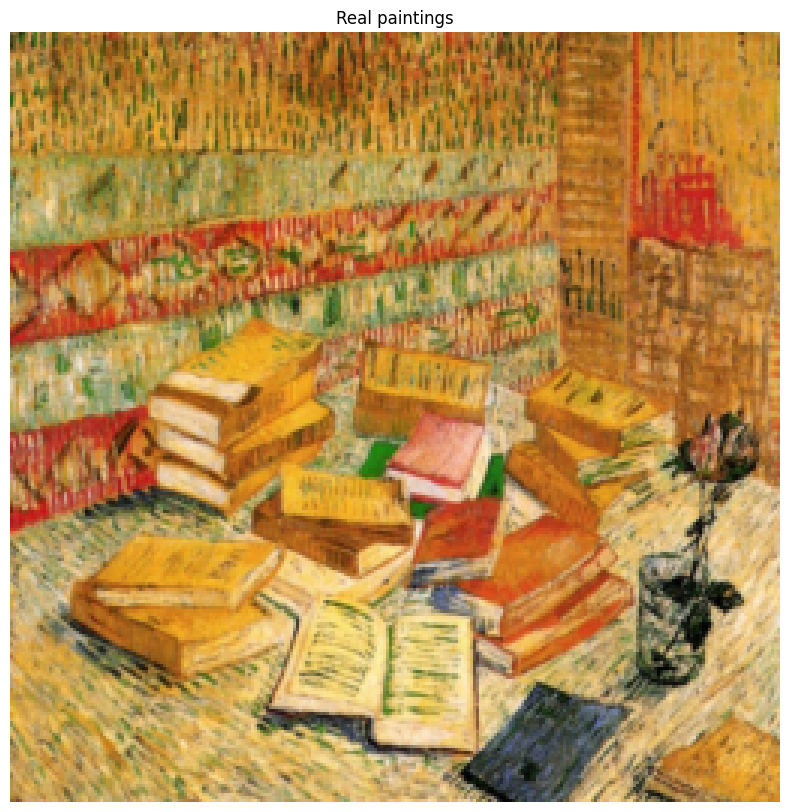

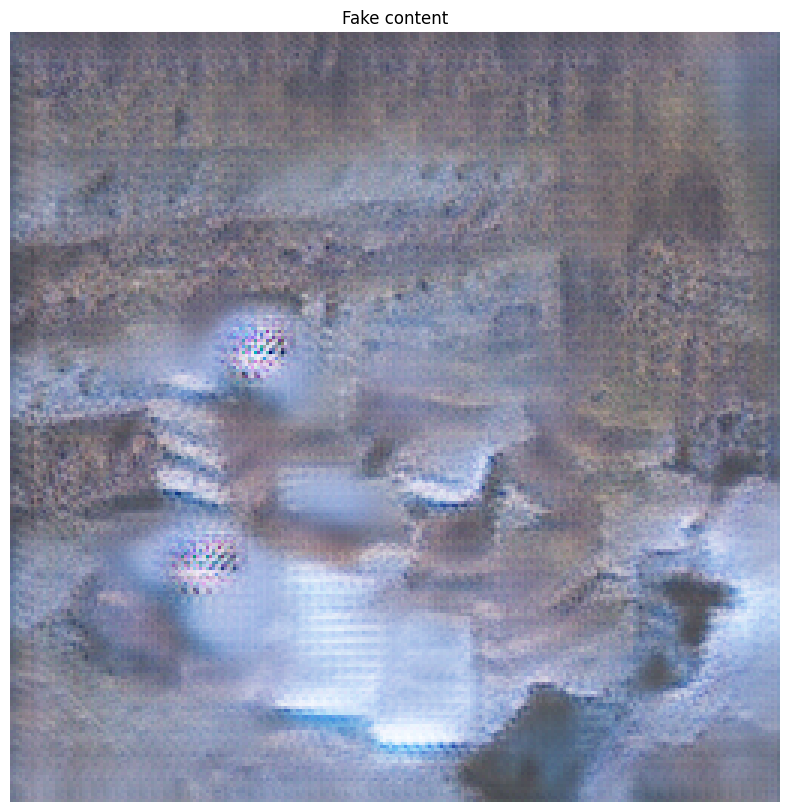

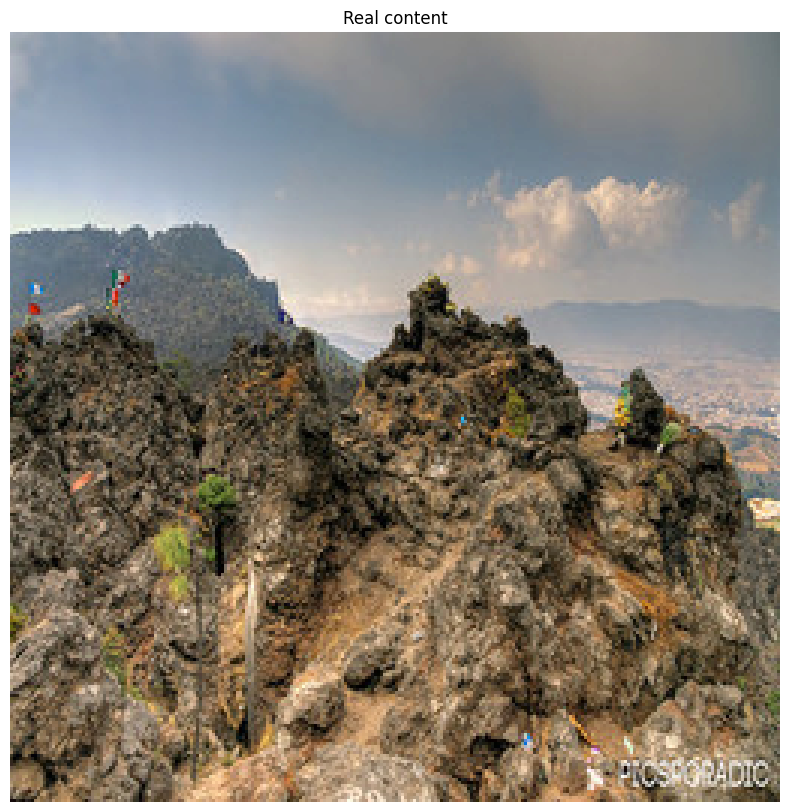

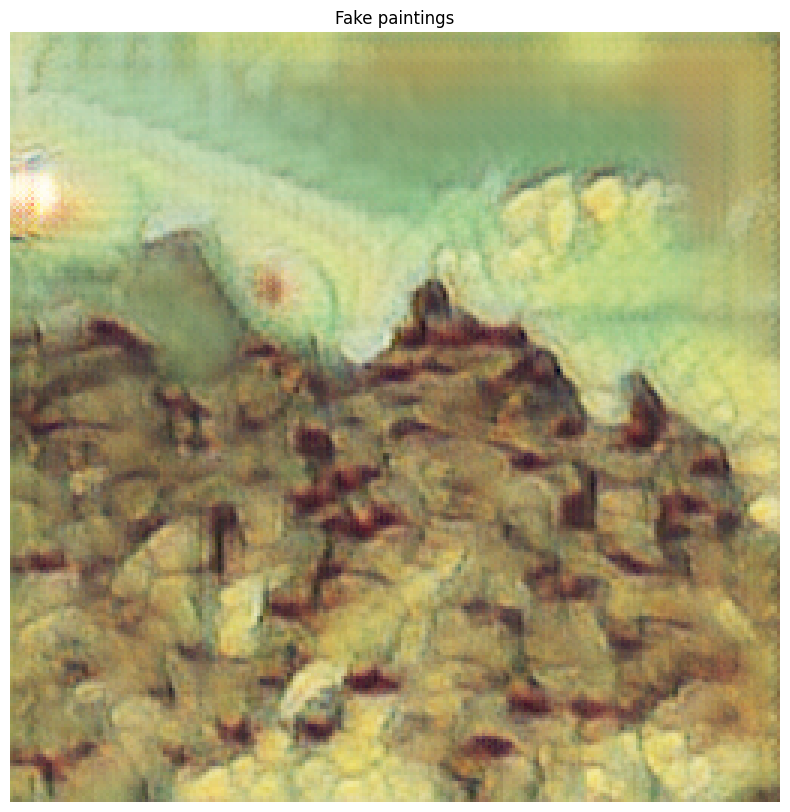

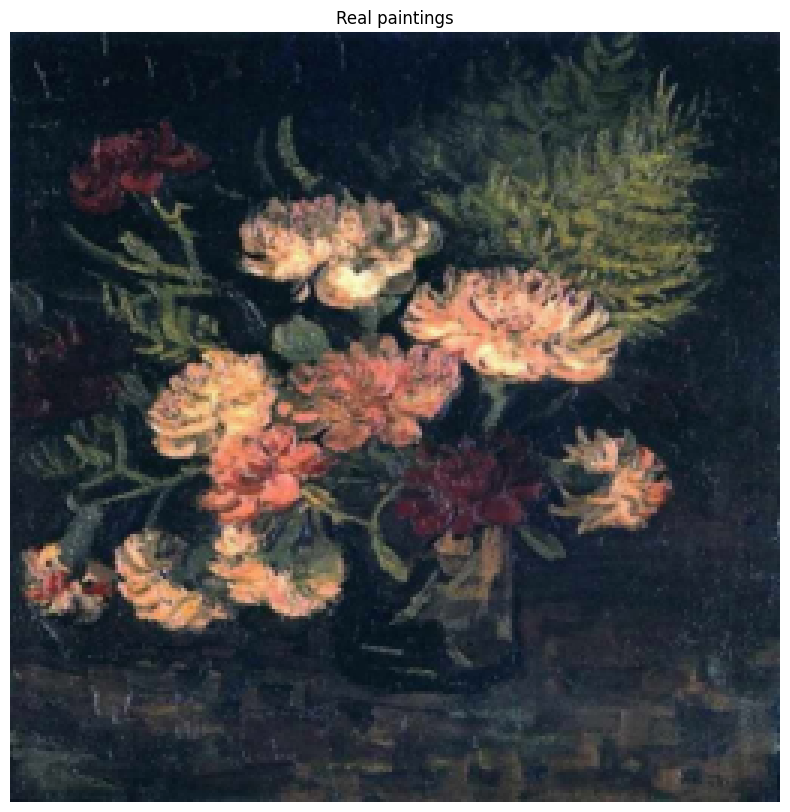

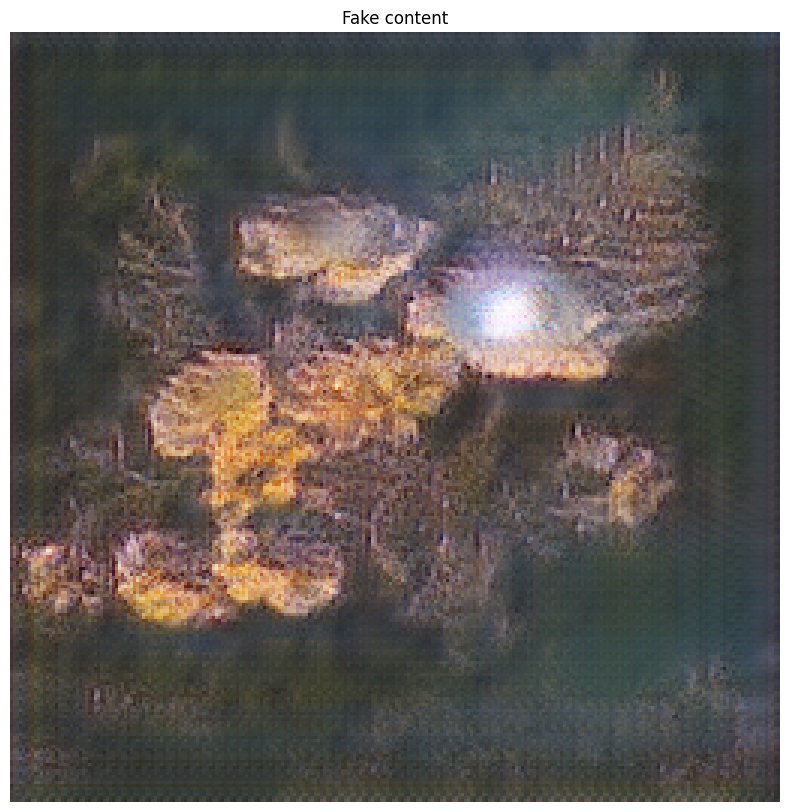

In [14]:
name = '1'
epochs = 20
netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

losses = training(netG_A2B, netG_B2A, netD_A, netD_B, epochs, name)